# **Stock Prices Predictions with Machine Learning**

This Notebook will contain all the data engineering, the data analysis and the modeling phases needed to predict stock prices using a deep learning model.
The stocks analyzed will be the following:
* IBM
* AAPL (Apple Inc.)
* AMZN (Amazon Inc.)
* GOOGL (Alphabet Inc.)


By now, only one source will be used: Yahoo! Finance.
More sources of data can be added later on, if additional data features from there would be considered to add useful information to the analysis.

## Data gathering

Gatering data from Yahoo Finance

Target symbols:

In [1]:
ibm = 'IBM' 
aapl = 'AAPL'
amzn = 'AMZN'
googl = 'GOOGL'

Setting dataset record start date and end date:
* start will be just set to 1st Genuary 1900, in order to retrieve the logest possible time series, further data segmentation would be conducted later in the analysis;
* end time will be today date.

In [2]:
import datetime

In [3]:
start = datetime.datetime(1900, 1, 1)
end = datetime.date.today()

## Gathering data from Yahoo! Finance

Data from Yahoo! Finance.

In [4]:
# yfinance is a Yahoo! Finance market data downloader,
# that allows to access Yahoo finance data after Yahoo
# has discontinued support for this API
import yfinance as yf

#### ***IBM*** data:

In [5]:
df_yf_ibm = yf.download(ibm, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


#### ***Apple Inc.*** data:

In [6]:
df_yf_aapl = yf.download(aapl, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


#### ***Amazon.com Inc.*** data:

In [7]:
df_yf_amzn = yf.download(amzn, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


#### ***Alphabet Inc.*** data:

In [8]:
df_yf_googl = yf.download(googl, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


## EDA

This section contains an exploratory data analysis on the dataset. This will allow to to have a more clean view of the source data features dynamics over time and to spot possible patterns in data, if any.

Data are provided in a straight order pandas dataframe (first record first).

#### ***IBM*** data:

Newest data available:

In [9]:
df_yf_ibm.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-12,121.000000,121.360001,120.089996,120.800003,120.800003,3868900
2021-02-16,120.150002,120.599998,119.360001,120.070000,120.070000,6638000
2021-02-17,119.269997,120.559998,119.019997,119.970001,119.970001,3959100
2021-02-18,120.500000,120.940002,119.699997,120.730003,120.730003,5398100
2021-02-19,120.750000,120.760002,118.379997,118.989998,118.989998,6575500


Oldest data available:

In [10]:
df_yf_ibm.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500


#### ***Apple Inc.*** data:

Newest data available:

In [11]:
df_yf_aapl.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-12,134.350006,135.529999,133.690002,135.369995,135.369995,60029300
2021-02-16,135.490005,136.009995,132.789993,133.190002,133.190002,80206200
2021-02-17,131.250000,132.220001,129.470001,130.839996,130.839996,97918500
2021-02-18,129.199997,130.000000,127.410004,129.710007,129.710007,96648100
2021-02-19,130.240005,130.710007,128.800003,129.869995,129.869995,87525900


Oldest data available:

In [12]:
df_yf_aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600


#### ***Amazon.com Inc.*** data:

Newest data available:

In [13]:
df_yf_amzn.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-12,3250.000000,3280.250000,3233.310059,3277.709961,3277.709961,2329300
2021-02-16,3254.050049,3308.300049,3253.590088,3268.949951,3268.949951,2563200
2021-02-17,3263.600098,3320.909912,3259.500000,3308.639893,3308.639893,3297500
2021-02-18,3282.419922,3338.000000,3273.939941,3328.229980,3328.229980,3027400
2021-02-19,3328.229980,3333.500000,3245.750000,3249.899902,3249.899902,4297200


Oldest data available:

In [14]:
df_yf_amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


#### ***Alphabet Inc.*** data:

Newest data available:

In [15]:
df_yf_googl.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-12,2079.770020,2099.500000,2073.570068,2095.030029,2095.030029,948500
2021-02-16,2091.750000,2145.139893,2091.750000,2110.699951,2110.699951,1548900
2021-02-17,2093.979980,2122.439941,2088.350098,2118.620117,2118.620117,1014700
2021-02-18,2105.000000,2121.989990,2093.330078,2105.810059,2105.810059,1127300
2021-02-19,2107.790039,2118.580078,2083.429932,2088.810059,2088.810059,1866100


Oldest data available:

In [16]:
df_yf_googl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


# Renaming dataframes

By now, as said before, I'll use Yahoo! Finance as the sole source of data, so, i will simply rename the dataframes.

In [17]:
df_ibm = df_yf_ibm

In [18]:
df_aapl = df_yf_aapl

In [19]:
df_amzn = df_yf_amzn

In [20]:
df_googl = df_yf_googl

## Data visualization

Some data visualization will help to spot data dynamics.

In [21]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

Stock volume history of IBM stock:

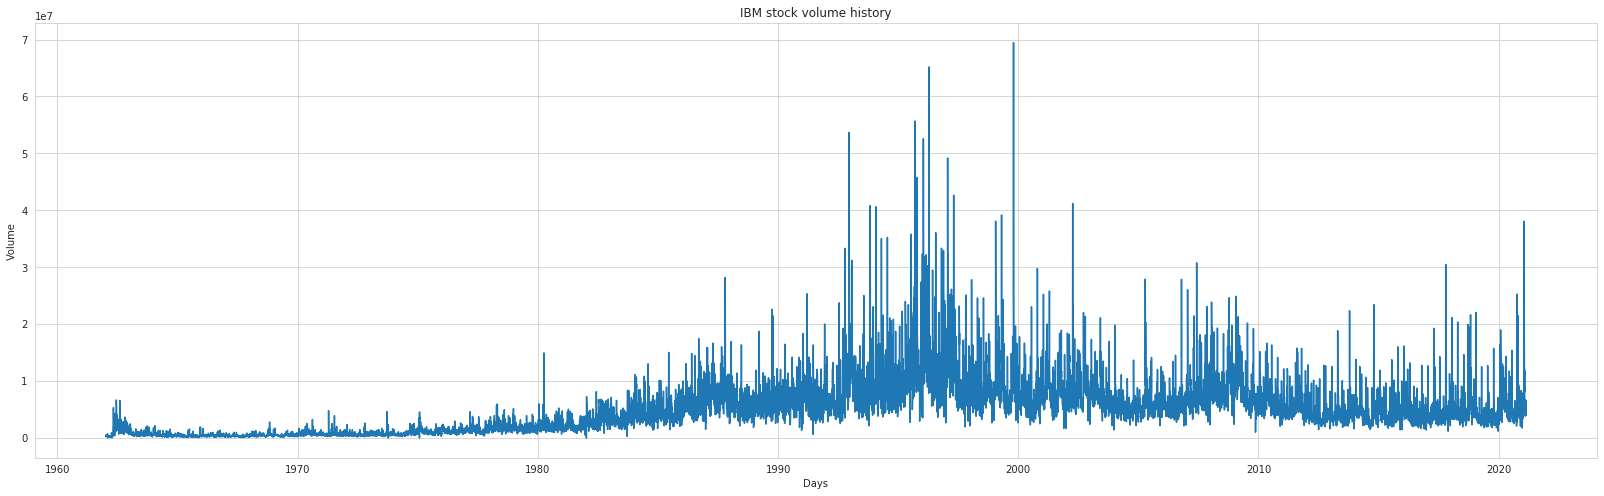

In [22]:
plt.figure(figsize=(28, 8))
plt.plot(df_ibm["Volume"])
plt.title('IBM stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [23]:
print("checking if any null values are present\n", df_ibm.isna().sum())

checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [24]:
print("checking if any null values are present\n", df_aapl.isna().sum())

checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [25]:
print("checking if any null values are present\n", df_amzn.isna().sum())

checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [26]:
print("checking if any null values are present\n", df_googl.isna().sum())

checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#### ***IBM*** data:

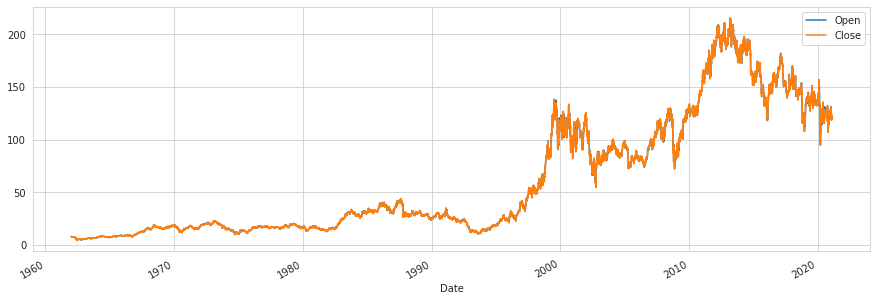

In [27]:
df_ibm[['Open', 'Close']].plot(legend=True,figsize=(15,5))

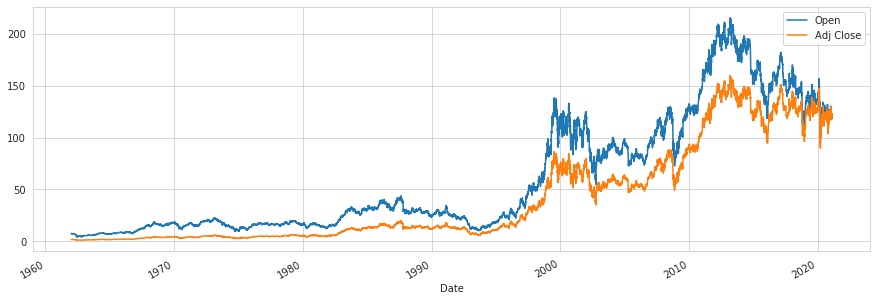

In [28]:
df_ibm[['Open', 'Adj Close']].plot(legend=True,figsize=(15,5))

Checking for inter-features correlation:

In [29]:
# Compute the correlation matrix
df_ibm_corr = df_ibm.corr()

In [30]:
import numpy as np

In [31]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_ibm_corr, dtype=bool))

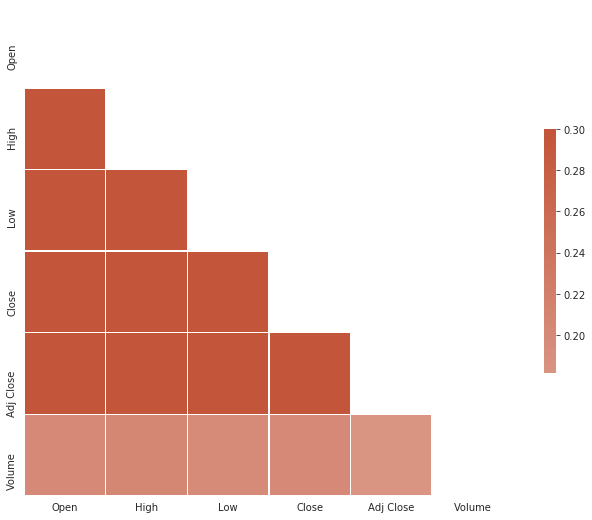

In [32]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_ibm_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Nominally, the Volume feature has a lower correlation with the other feature but, indeed, we can presume it contains very useful data, from the moment that we know that Open, High, Low and Close value are all mostly linearly correlated to Adj Close value (our target feature).

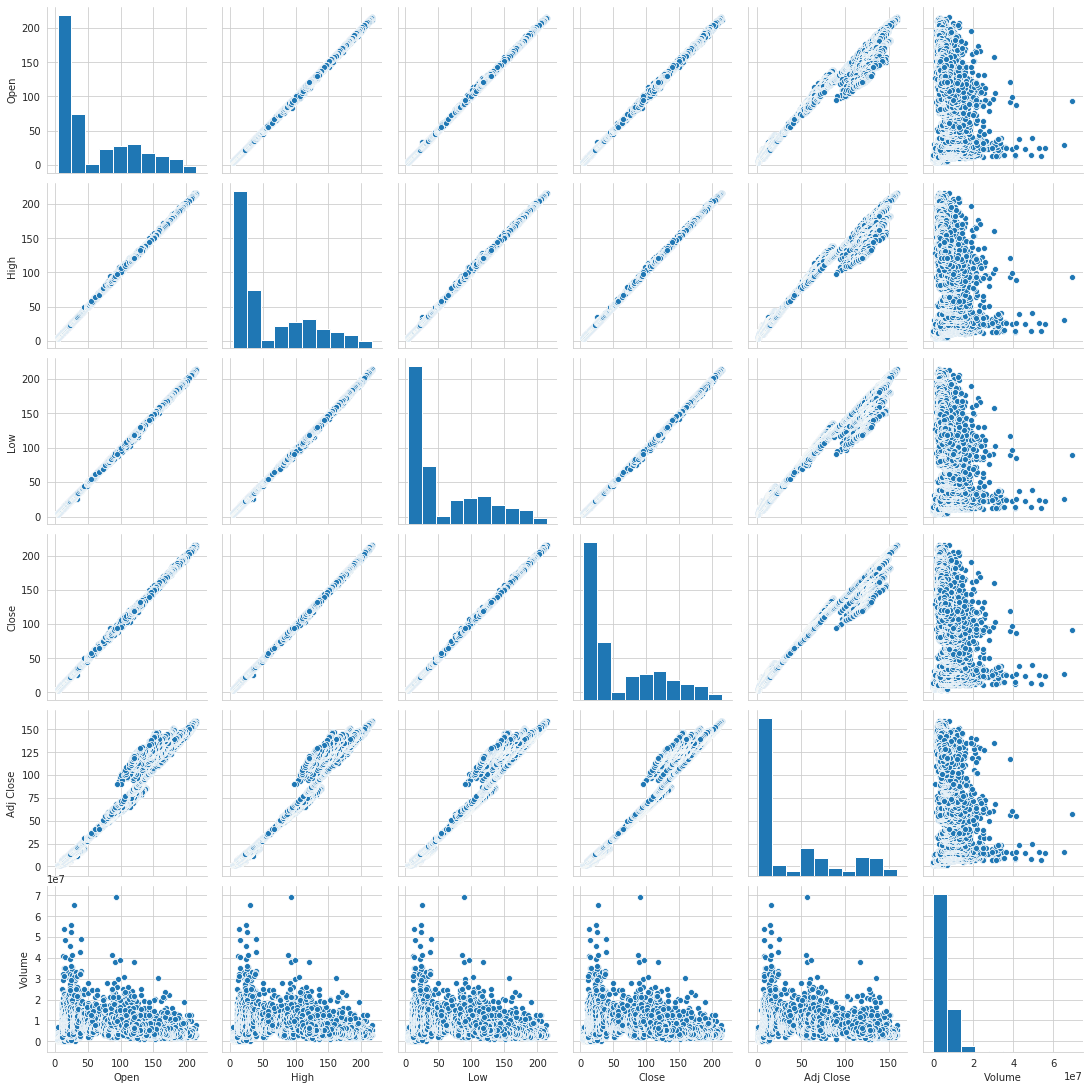

In [33]:
sns.pairplot(df_ibm)

From what we can see in the pairplot, we can expect the volume to be pretty high when the value of the stock is low and to get lower when the value of the stock is high.
We can run an additional visual check on this hypotesis:

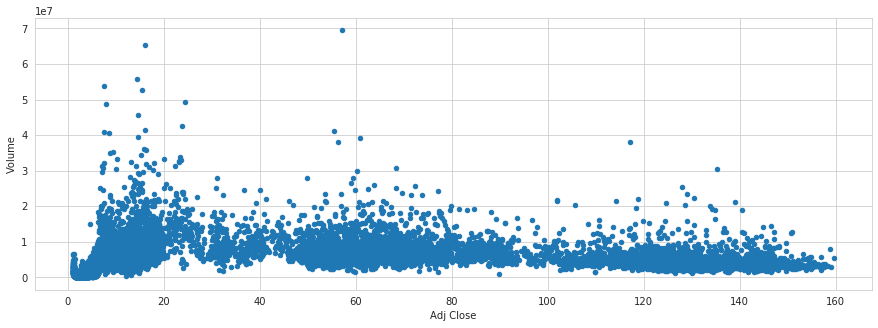

In [34]:
df_ibm.plot.scatter('Adj Close', 'Volume', legend=True, figsize=(15, 5))

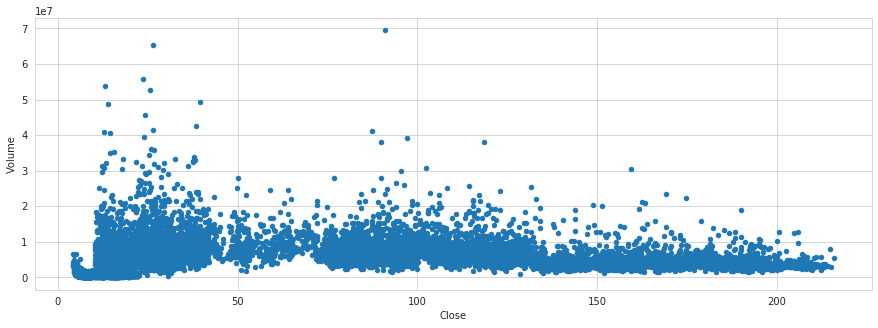

In [35]:
df_ibm.plot.scatter('Close', 'Volume', legend=True, figsize=(15, 5))

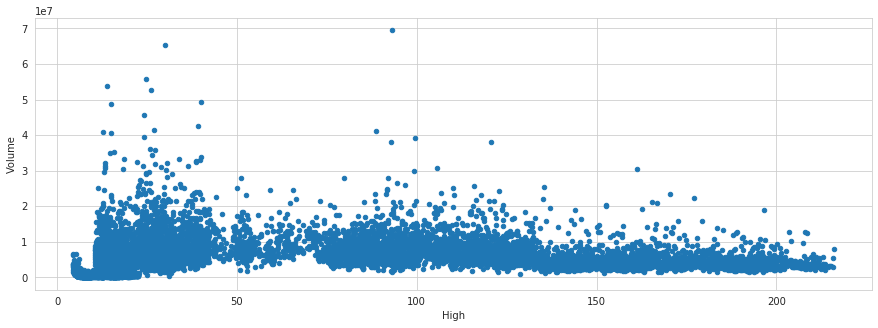

In [36]:
df_ibm.plot.scatter('High', 'Volume', legend=True, figsize=(15, 5))

More generally, it seems like specific values of the stock is realated to specific volume amount... Let's check another couple of stocks to see if this is a general beahvior in this kind of stock:

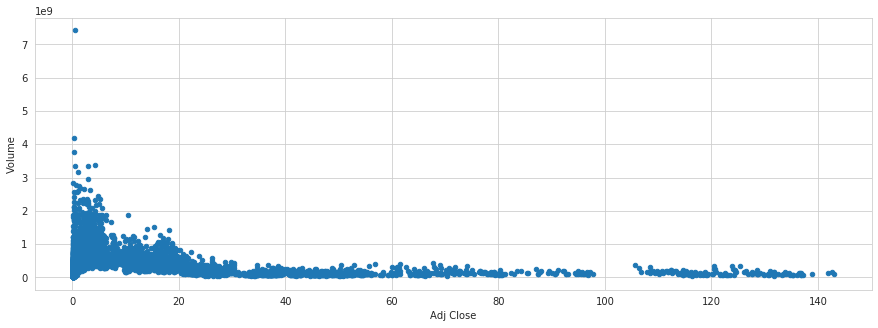

In [37]:
df_aapl.plot.scatter('Adj Close', 'Volume', legend=True, figsize=(15, 5))

**Apple Inc.** stock volume is even more related to Adjusted Close value. 

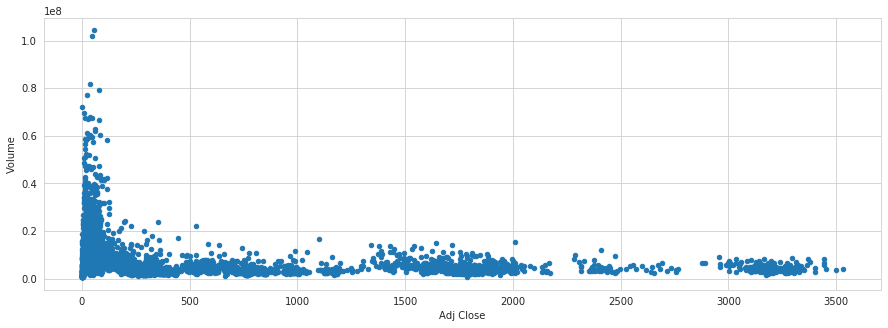

In [38]:
df_amzn.plot.scatter('Adj Close', 'Volume', legend=True, figsize=(15, 5))

**Amazon.com** stock too shows this behavior...

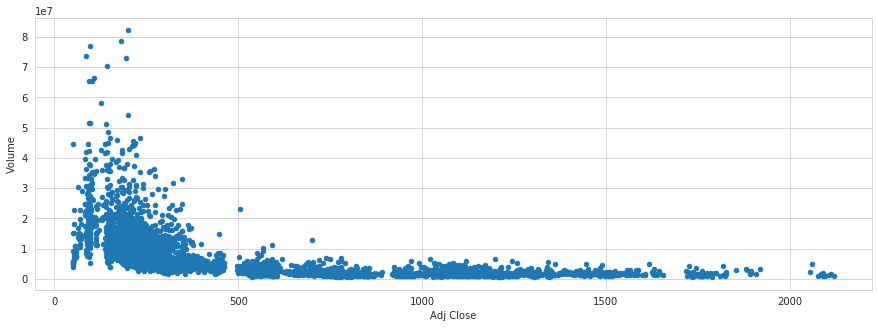

In [39]:
df_googl.plot.scatter('Adj Close', 'Volume', legend=True, figsize=(15, 5))

**Alphabet** stocks behavior confirms that.

#### ***Apple Inc.*** data:

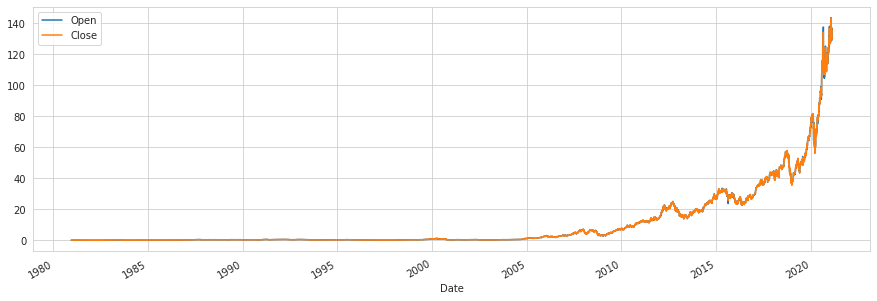

In [40]:
df_aapl[['Open', 'Close']].plot(legend=True,figsize=(15,5))

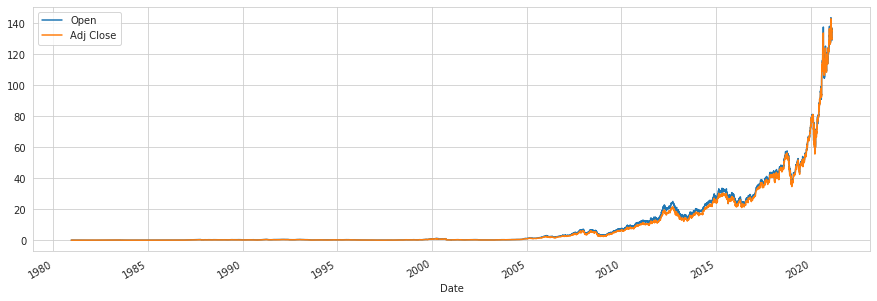

In [41]:
df_aapl[['Open', 'Adj Close']].plot(legend=True,figsize=(15,5))

Checking for inter-features correlation:

In [42]:
# Compute the correlation matrix
df_aapl_corr = df_aapl.corr()

In [43]:
import numpy as np

In [44]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_aapl_corr, dtype=bool))

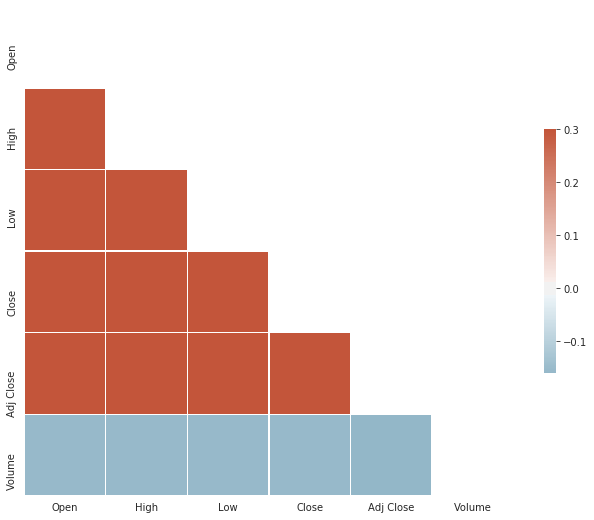

In [45]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_aapl_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

"Volume" feature has a lower correlation with the other features here we can clearly spot the expected correlation as hypotized about IBM stock.

In [46]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 4.5 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [47]:
#import plotly.graph_objects as go
#import chart_studio.plotly as py

In [48]:
trace_ibm = {
    'x': df_ibm.index,
    'open': df_ibm.Open,
    'close': df_ibm.Close,
    'high': df_ibm.High,
    'low': df_ibm.Low,
    'type': 'candlestick',
    'name': 'IBM',
    'showlegend': True
}


In [58]:
import plotly.graph_objs as go

In [59]:
ibm_data = [trace_ibm]
# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'IBM (IBM) Moving Averages',
        'font': {
            'size': 15
        }
    }
})


In [ ]:
#py.iplot(ibm_data)

In [ ]:
#ax = sns.boxplot(x="Open", y="Close", data=df_ibm)

### Feature Engineering

In this section we well use some basic feature engineering on the data.

#### Moving average

Moving average is a value that can smooth the data in order to have good predictions.
I'll use this value for three purposes:
* Detect if some seasonal pattern is present in data
* A benchmark for deep learning model performance
* An additional feature to be used to train deep learning model

In [63]:
from ta_utils.technical_indicators import moving_average

#### IBM stock moving averages

In [66]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_ibm[column_name] = moving_average(df_ibm['Adj Close'], window_size=mds)

In [67]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [68]:
df_ibm.fillna(method='backfill', inplace=True)

In [69]:
df_ibm.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2021-02-12,121.000000,121.360001,120.089996,120.800003,120.800003,3868900,120.200284,121.306254,122.992767
2021-02-16,120.150002,120.599998,119.360001,120.070000,120.070000,6638000,120.312235,120.974906,122.934634
2021-02-17,119.269997,120.559998,119.019997,119.970001,119.970001,3959100,120.522736,120.607473,122.894434
2021-02-18,120.500000,120.940002,119.699997,120.730003,120.730003,5398100,120.840816,120.225739,122.798580
2021-02-19,120.750000,120.760002,118.379997,118.989998,118.989998,6575500,120.797401,119.679540,122.717268


In [70]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,1.831034,1.806507,1.787152
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,1.831034,1.806507,1.787152
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,1.831034,1.806507,1.787152
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,1.831034,1.806507,1.787152
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,1.831034,1.806507,1.787152


In [71]:
start_date = '1999-1-1'
end_date = '2000-12-31'
df_ibm[start_date:end_date]

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1999-01-04,92.50000,93.2500,90.75000,91.50000,57.222702,8149600,57.336052,54.627357,51.017732
1999-01-05,91.50000,94.9375,91.40625,94.81250,59.294292,9907600,57.900853,55.024086,51.318054
1999-01-06,95.15625,96.3750,94.25000,94.37500,59.020687,9539600,58.287810,55.361208,51.614465
1999-01-07,93.96875,96.1875,93.50000,95.09375,59.470184,8306800,58.536012,55.705169,51.910498
1999-01-08,95.50000,96.0000,92.81250,93.78125,58.649353,9176800,58.616137,55.988545,52.181919
...,...,...,...,...,...,...,...,...,...
2000-12-22,84.50000,89.3750,84.50000,89.00000,56.185520,9514000,56.662942,59.071738,61.002286
2000-12-26,89.00000,89.5625,84.25000,84.81250,53.541969,6052300,56.019807,58.641666,60.697857
2000-12-27,84.75000,88.1250,83.56250,84.68750,53.463047,8245100,55.439805,58.225405,60.365840


In [72]:
df_ibm.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '10_ac_ma',
       '20_ac_ma', '50_ac_ma'],
      dtype='object')

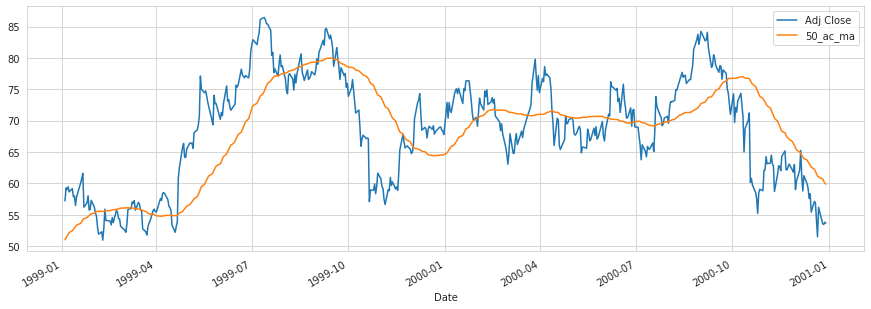

In [73]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

### Seasonal pattern hypotesis on IBM stock

My hypotesis is that IBM can have an annual pattern, from september to october.
Let's run a more precise visual check:

1999-2000 period:

In [89]:
start_date = '1999-08-1'
end_date = '2000-11-30'

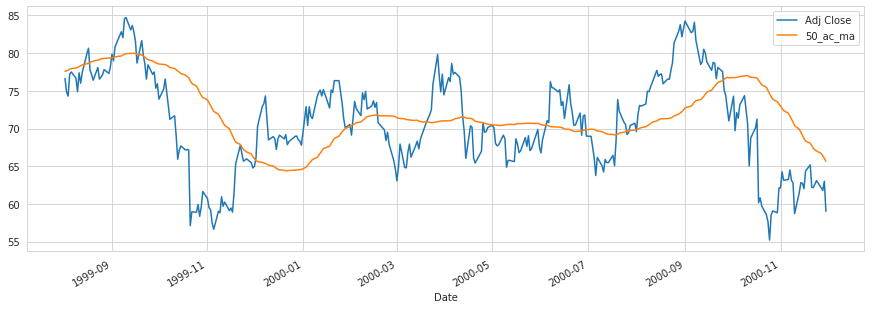

In [90]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

2000-2001 period:

In [91]:
start_date = '2000-08-1'
end_date = '2001-11-30'

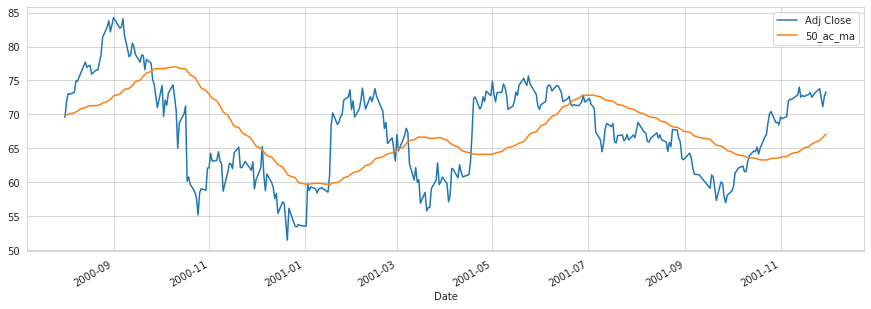

In [92]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

This seems to confirm my theory.

2001-2002 period:

In [93]:
start_date = '2001-08-1'
end_date = '2002-11-30'

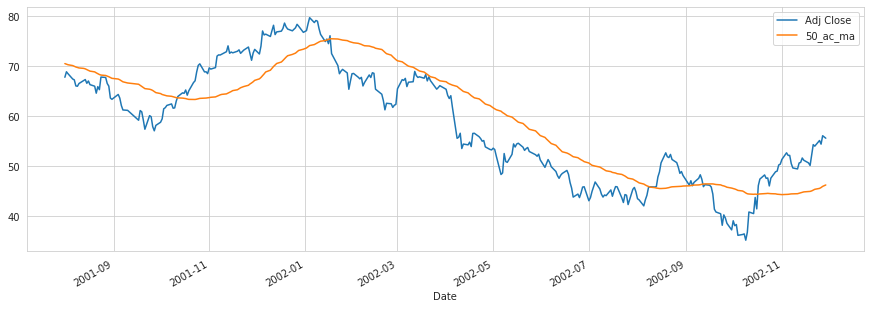

In [94]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

Looking to this one, I'm not sure that this applies to all periods. So, I will just analyze the last three years

In [79]:
start_date = '2019-08-1'
end_date = '2020-11-30'

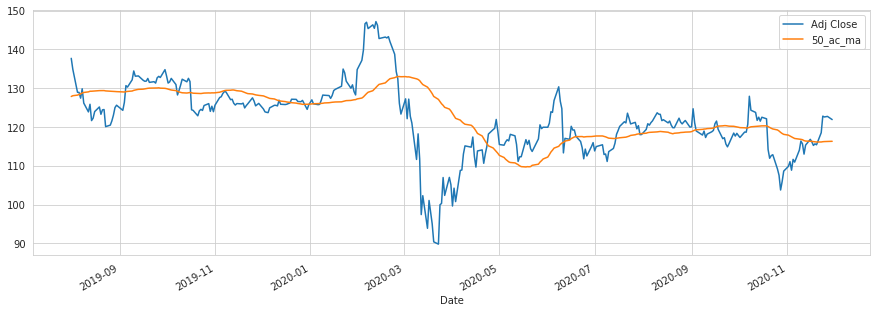

In [80]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

In [81]:
start_date = '2018-08-1'
end_date = '2019-11-30'

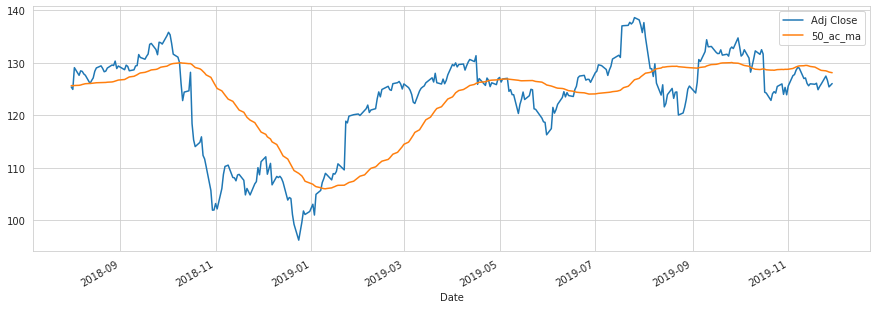

In [82]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

In [83]:
start_date = '2017-08-1'
end_date = '2018-11-30'

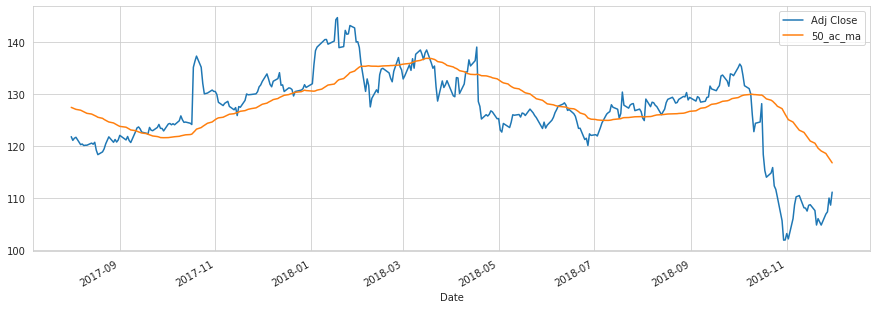

In [84]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

It seems quite present, but is not so evident anymore.

#### Apple stock moving averages

In [74]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_aapl[column_name] = moving_average(df_aapl['Adj Close'], window_size=mds)

In [75]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,NaN,NaN,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,NaN,NaN,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,NaN,NaN,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [76]:
df_aapl.fillna(method='backfill', inplace=True)

In [77]:
df_aapl.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2021-02-12,134.350006,135.529999,133.690002,135.369995,135.369995,60029300,135.522359,135.666208,131.056535
2021-02-16,135.490005,136.009995,132.789993,133.190002,133.190002,80206200,135.447374,135.978194,131.262408
2021-02-17,131.250000,132.220001,129.470001,130.839996,130.839996,97918500,135.052515,136.138230,131.424077
2021-02-18,129.199997,130.000000,127.410004,129.710007,129.710007,96648100,134.649500,136.032081,131.576925
2021-02-19,130.240005,130.710007,128.800003,129.869995,129.869995,87525900,133.917999,135.692292,131.703018


In [78]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,0.101975,0.108974,0.104248
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,0.101975,0.108974,0.104248
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,0.101975,0.108974,0.104248
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,0.101975,0.108974,0.104248
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,0.101975,0.108974,0.104248


In [88]:
start_date = '2020-01-1'
end_date = '2021-01-30'

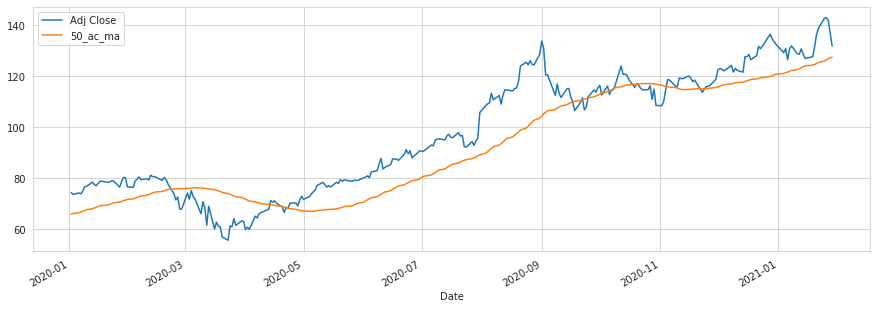

In [89]:
df_aapl[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

#### Amazon.com stock moving averages

In [90]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_amzn[column_name] = moving_average(df_amzn['Adj Close'], window_size=mds)

In [96]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,NaN,NaN,NaN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,NaN,NaN,NaN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [97]:
df_amzn.fillna(method='backfill', inplace=True)

In [98]:
df_amzn.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2021-02-12,3250.000000,3280.250000,3233.310059,3277.709961,3277.709961,2329300,3317.291968,3277.852979,3222.085181
2021-02-16,3254.050049,3308.300049,3253.590088,3268.949951,3268.949951,2563200,3309.898975,3286.087976,3223.393579
2021-02-17,3263.600098,3320.909912,3259.500000,3308.639893,3308.639893,3297500,3302.762964,3295.481970,3225.831777
2021-02-18,3282.419922,3338.000000,3273.939941,3328.229980,3328.229980,3027400,3304.332959,3298.724475,3229.144775
2021-02-19,3328.229980,3333.500000,3245.750000,3249.899902,3249.899902,4297200,3296.222949,3295.869971,3230.982773


In [99]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1.597396,1.57474,1.772813
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1.597396,1.57474,1.772813
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1.597396,1.57474,1.772813
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1.597396,1.57474,1.772813
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1.597396,1.57474,1.772813


In [100]:
start_date = '2020-01-1'
end_date = '2021-01-30'

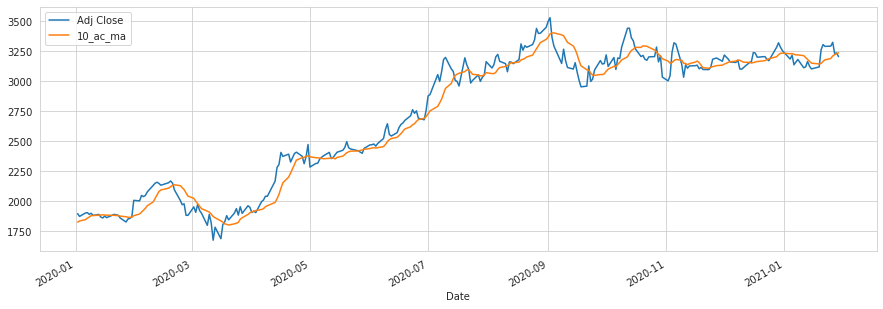

In [102]:
df_amzn[start_date:end_date][['Adj Close', '10_ac_ma']].plot(legend=True,figsize=(15,5))

#### Alphabet Inc. stock moving averages

In [103]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_googl[column_name] = moving_average(df_googl['Adj Close'], window_size=mds)

In [104]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN,NaN
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,NaN,NaN,NaN
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,NaN,NaN,NaN
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,NaN,NaN,NaN
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [105]:
df_googl.fillna(method='backfill', inplace=True)

In [106]:
df_googl.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2021-02-12,2079.770020,2099.500000,2073.570068,2095.030029,2095.030029,948500,2044.369971,1945.714978,1834.833992
2021-02-16,2091.750000,2145.139893,2091.750000,2110.699951,2110.699951,1548900,2066.132971,1964.868976,1840.548591
2021-02-17,2093.979980,2122.439941,2088.350098,2118.620117,2118.620117,1014700,2086.082983,1981.576483,1846.484194
2021-02-18,2105.000000,2121.989990,2093.330078,2105.810059,2105.810059,1127300,2090.776001,1992.863489,1852.125195
2021-02-19,2107.790039,2118.580078,2083.429932,2088.810059,2088.810059,1866100,2094.294019,2003.096490,1857.560796


In [107]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,52.432933,52.692943,63.586987
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,52.432933,52.692943,63.586987
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,52.432933,52.692943,63.586987
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,52.432933,52.692943,63.586987
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,52.432933,52.692943,63.586987


In [108]:
start_date = '2020-01-1'
end_date = '2021-01-30'

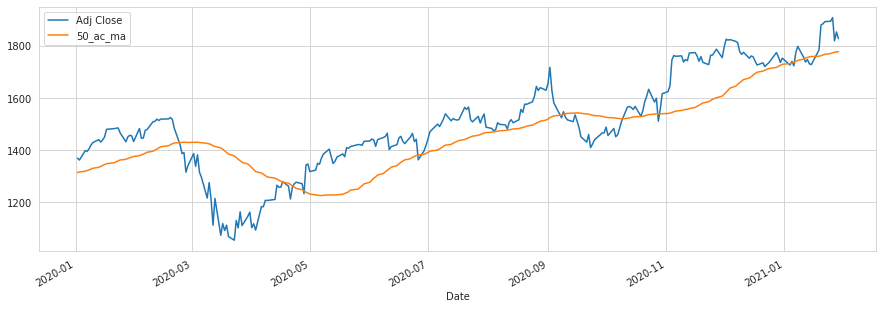

In [110]:
df_googl[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

### Bollinger bands

Another interesting feature that can be computed from Adjusted Close are Bollinger bands.

In [62]:
from ta_utils.technical_indicators import bollinger_bands

IBM bollinger bands:

In [116]:
# bollinger bands window sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    ub_column_name = "%s_ac_bb_u" %(str(mds))
    lb_column_name = "%s_ac_bb_l" %(str(mds))
    df_ibm[ub_column_name] = bollinger_bands(df_ibm['Adj Close'], window_size=mds)[1]
    df_ibm[lb_column_name] = bollinger_bands(df_ibm['Adj Close'], window_size=mds)[2]

In [127]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,1.831034,1.806507,1.787152,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,1.831034,1.806507,1.787152,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,1.831034,1.806507,1.787152,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,1.831034,1.806507,1.787152,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,1.831034,1.806507,1.787152,NaN,NaN,NaN,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [128]:
df_ibm.fillna(method='backfill', inplace=True)

In [129]:
df_ibm.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
2021-02-12,121.000000,121.360001,120.089996,120.800003,120.800003,3868900,120.200284,121.306254,122.992767,123.628698,116.771870,129.077036,113.535473,129.279414,116.706120
2021-02-16,120.150002,120.599998,119.360001,120.070000,120.070000,6638000,120.312235,120.974906,122.934634,123.630615,116.993855,128.331988,113.617823,129.275412,116.593856
2021-02-17,119.269997,120.559998,119.019997,119.970001,119.970001,3959100,120.522736,120.607473,122.894434,123.387170,117.658302,127.337892,113.877054,129.285204,116.503663
2021-02-18,120.500000,120.940002,119.699997,120.730003,120.730003,5398100,120.840816,120.225739,122.798580,122.801605,118.880026,125.884348,114.567129,129.172198,116.424963
2021-02-19,120.750000,120.760002,118.379997,118.989998,118.989998,6575500,120.797401,119.679540,122.717268,122.910881,118.683921,123.044776,116.314304,129.180605,116.253931


In [130]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,1.831034,1.806507,1.787152,1.885422,1.776646,1.878527,1.734487,1.854736,1.719568
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,1.831034,1.806507,1.787152,1.885422,1.776646,1.878527,1.734487,1.854736,1.719568
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,1.831034,1.806507,1.787152,1.885422,1.776646,1.878527,1.734487,1.854736,1.719568
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,1.831034,1.806507,1.787152,1.885422,1.776646,1.878527,1.734487,1.854736,1.719568
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,1.831034,1.806507,1.787152,1.885422,1.776646,1.878527,1.734487,1.854736,1.719568


In [131]:
start_date = '2020-01-1'
end_date = '2021-01-30'

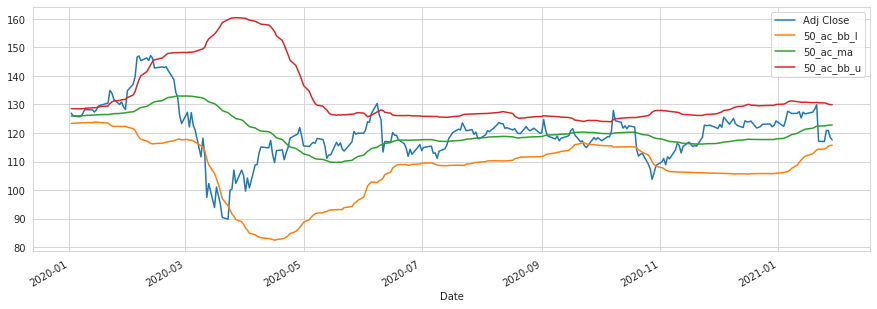

In [136]:
df_ibm[start_date:end_date][['Adj Close', '50_ac_bb_l', '50_ac_ma','50_ac_bb_u']].plot(legend=True,figsize=(15,5))

AMZN bollinger bands:

In [137]:
# bollinger bands window sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    ub_column_name = "%s_ac_bb_u" %(str(mds))
    lb_column_name = "%s_ac_bb_l" %(str(mds))
    df_amzn[ub_column_name] = bollinger_bands(df_amzn['Adj Close'], window_size=mds)[1]
    df_amzn[lb_column_name] = bollinger_bands(df_amzn['Adj Close'], window_size=mds)[2]

In [138]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1.597396,1.57474,1.772813,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1.597396,1.57474,1.772813,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1.597396,1.57474,1.772813,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1.597396,1.57474,1.772813,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1.597396,1.57474,1.772813,NaN,NaN,NaN,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [139]:
df_amzn.fillna(method='backfill', inplace=True)

In [140]:
df_amzn.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
2021-02-12,3250.000000,3280.250000,3233.310059,3277.709961,3277.709961,2329300,3317.291968,3277.852979,3222.085181,3389.552311,3245.031625,3419.109022,3136.596935,3375.172588,3068.997774
2021-02-16,3254.050049,3308.300049,3253.590088,3268.949951,3268.949951,2563200,3309.898975,3286.087976,3223.393579,3385.571219,3234.226730,3401.585069,3170.590883,3376.951228,3069.835930
2021-02-17,3263.600098,3320.909912,3259.500000,3308.639893,3308.639893,3297500,3302.762964,3295.481970,3225.831777,3360.352910,3245.173017,3381.043039,3209.920902,3380.877493,3070.786062
2021-02-18,3282.419922,3338.000000,3273.939941,3328.229980,3328.229980,3027400,3304.332959,3298.724475,3229.144775,3363.927436,3244.738482,3384.078129,3213.370821,3385.745319,3072.544232
2021-02-19,3328.229980,3333.500000,3245.750000,3249.899902,3249.899902,4297200,3296.222949,3295.869971,3230.982773,3361.491566,3230.954332,3383.838238,3207.901704,3386.327284,3075.638263


In [141]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1.597396,1.57474,1.772813,1.93311,1.261682,1.836333,1.313146,2.458803,1.086822
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1.597396,1.57474,1.772813,1.93311,1.261682,1.836333,1.313146,2.458803,1.086822
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1.597396,1.57474,1.772813,1.93311,1.261682,1.836333,1.313146,2.458803,1.086822
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1.597396,1.57474,1.772813,1.93311,1.261682,1.836333,1.313146,2.458803,1.086822
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1.597396,1.57474,1.772813,1.93311,1.261682,1.836333,1.313146,2.458803,1.086822


In [142]:
start_date = '2020-01-1'
end_date = '2021-01-30'

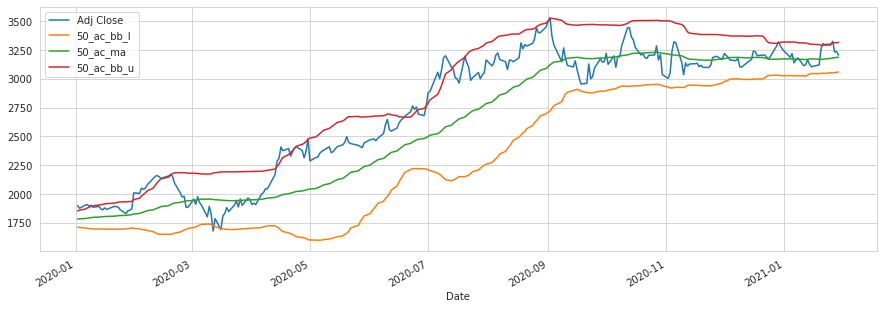

In [144]:
df_amzn[start_date:end_date][['Adj Close', '50_ac_bb_l', '50_ac_ma','50_ac_bb_u']].plot(legend=True,figsize=(15,5))

Apple bollinger bands:

In [149]:
# bollinger bands window sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    ub_column_name = "%s_ac_bb_u" %(str(mds))
    lb_column_name = "%s_ac_bb_l" %(str(mds))
    df_aapl[ub_column_name] = bollinger_bands(df_aapl['Adj Close'], window_size=mds)[1]
    df_aapl[lb_column_name] = bollinger_bands(df_aapl['Adj Close'], window_size=mds)[2]

In [150]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,0.101975,0.108974,0.104248,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,0.101975,0.108974,0.104248,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,0.101975,0.108974,0.104248,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,0.101975,0.108974,0.104248,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,0.101975,0.108974,0.104248,NaN,NaN,NaN,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [151]:
df_aapl.fillna(method='backfill', inplace=True)

In [152]:
df_aapl.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
2021-02-12,134.350006,135.529999,133.690002,135.369995,135.369995,60029300,135.522359,135.666208,131.056535,137.914301,133.130416,144.087912,127.244505,142.327544,119.785526
2021-02-16,135.490005,136.009995,132.789993,133.190002,133.190002,80206200,135.447374,135.978194,131.262408,138.093331,132.801417,143.449006,128.507381,142.298640,120.226176
2021-02-17,131.250000,132.220001,129.470001,130.839996,130.839996,97918500,135.052515,136.138230,131.424077,138.995849,131.109180,142.966393,129.310068,142.185129,120.663025
2021-02-18,129.199997,130.000000,127.410004,129.710007,129.710007,96648100,134.649500,136.032081,131.576925,139.821352,129.477647,143.199620,128.864541,142.007567,121.146283
2021-02-19,130.240005,130.710007,128.800003,129.869995,129.869995,87525900,133.917999,135.692292,131.703018,139.545200,128.290798,143.360206,128.024378,141.887890,121.518145


In [153]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,0.101975,0.108974,0.104248,0.124365,0.079585,0.132002,0.085946,0.126685,0.081811
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,0.101975,0.108974,0.104248,0.124365,0.079585,0.132002,0.085946,0.126685,0.081811
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,0.101975,0.108974,0.104248,0.124365,0.079585,0.132002,0.085946,0.126685,0.081811
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,0.101975,0.108974,0.104248,0.124365,0.079585,0.132002,0.085946,0.126685,0.081811
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,0.101975,0.108974,0.104248,0.124365,0.079585,0.132002,0.085946,0.126685,0.081811


In [154]:
start_date = '2020-01-1'
end_date = '2021-01-30'

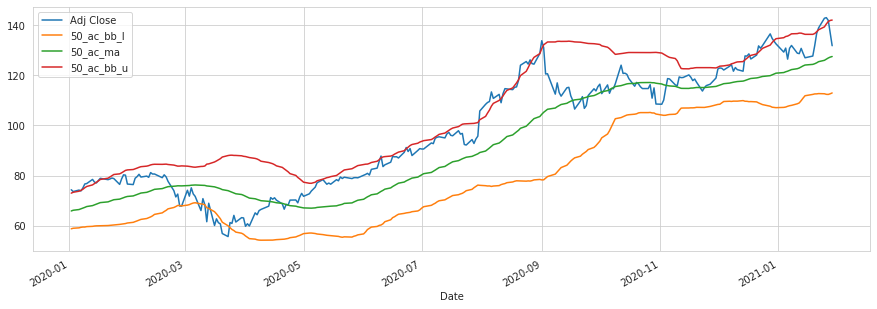

In [155]:
df_aapl[start_date:end_date][['Adj Close', '50_ac_bb_l', '50_ac_ma','50_ac_bb_u']].plot(legend=True,figsize=(15,5))

Alphabet Inc. bollinger bands:

In [156]:
# bollinger bands window sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    ub_column_name = "%s_ac_bb_u" %(str(mds))
    lb_column_name = "%s_ac_bb_l" %(str(mds))
    df_googl[ub_column_name] = bollinger_bands(df_googl['Adj Close'], window_size=mds)[1]
    df_googl[lb_column_name] = bollinger_bands(df_googl['Adj Close'], window_size=mds)[2]

In [157]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,52.432933,52.692943,63.586987,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,52.432933,52.692943,63.586987,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,52.432933,52.692943,63.586987,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,52.432933,52.692943,63.586987,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,52.432933,52.692943,63.586987,NaN,NaN,NaN,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [158]:
df_googl.fillna(method='backfill', inplace=True)

In [159]:
df_googl.tail()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
2021-02-12,2079.770020,2099.500000,2073.570068,2095.030029,2095.030029,948500,2044.369971,1945.714978,1834.833992,2193.046774,1895.693167,2186.006374,1705.423582,2076.437444,1593.230539
2021-02-16,2091.750000,2145.139893,2091.750000,2110.699951,2110.699951,1548900,2066.132971,1964.868976,1840.548591,2174.673734,1957.592208,2192.710977,1737.026974,2094.405644,1586.691538
2021-02-17,2093.979980,2122.439941,2088.350098,2118.620117,2118.620117,1014700,2086.082983,1981.576483,1846.484194,2126.467383,2045.698584,2202.624080,1760.528886,2112.159135,1580.809254
2021-02-18,2105.000000,2121.989990,2093.330078,2105.810059,2105.810059,1127300,2090.776001,1992.863489,1852.125195,2127.885024,2053.666978,2215.137461,1770.589516,2127.626424,1576.623967
2021-02-19,2107.790039,2118.580078,2083.429932,2088.810059,2088.810059,1866100,2094.294019,2003.096490,1857.560796,2120.949812,2067.638226,2223.129983,1783.062998,2140.850093,1574.271498


In [160]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma,10_ac_bb_u,10_ac_bb_l,20_ac_bb_u,20_ac_bb_l,50_ac_bb_u,50_ac_bb_l
Date,,,,,,,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,52.432933,52.692943,63.586987,55.781053,49.084813,56.933168,48.452718,88.331593,38.842381
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,52.432933,52.692943,63.586987,55.781053,49.084813,56.933168,48.452718,88.331593,38.842381
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,52.432933,52.692943,63.586987,55.781053,49.084813,56.933168,48.452718,88.331593,38.842381
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,52.432933,52.692943,63.586987,55.781053,49.084813,56.933168,48.452718,88.331593,38.842381
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,52.432933,52.692943,63.586987,55.781053,49.084813,56.933168,48.452718,88.331593,38.842381


In [131]:
start_date = '2020-01-1'
end_date = '2021-01-30'

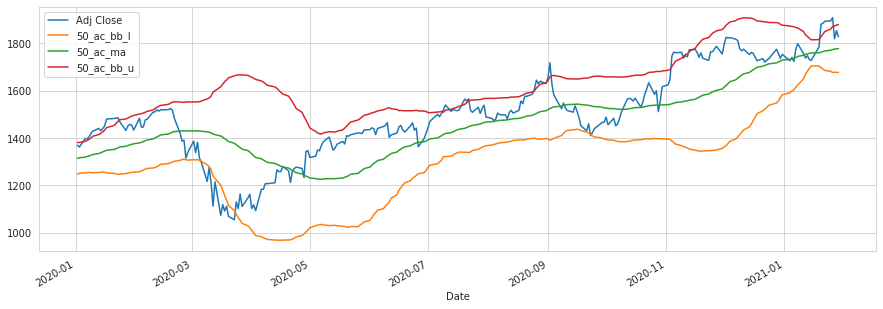

In [161]:
df_googl[start_date:end_date][['Adj Close', '50_ac_bb_l', '50_ac_ma','50_ac_bb_u']].plot(legend=True,figsize=(15,5))

### Hyperparameters Tuning

DeepAR is the model of choice of this project.
This model expects input data to be already test-train splitted.
A big part of the model design has to be done looking close at data.
More specifically, defining these two hyperparameters about the data:
* Context length
* Prediction length

### Prediction length

This is the length of the time series future predictions in days. It will be conveniently set to 5 days (exactly a week of trading hours) because a shorter interval would be of little significance.
A longer interval could be interesting from an application point of view, but it can be challenging in terms of model performances.

### Context length

Context length can be either:
* chosen as a fixed value (e.g. 2 x prediction_length),
* designed on patterns or seasonality observed in the data.

To explore this second option, we will refer to what we've found during the EDA stage.

In [163]:
from source_deepar import deepar_utils
#Define parameters
interval = 'D' #Use D or H

assert interval == 'D' or interval == 'H'

if interval == 'D':
    prediction_length = 7 #when interval = D    
    context_length = prediction_length*2
elif interval == 'H':
    prediction_length = 2184 #when interval = H
    context_length = prediction_length*2
    
    
mnemonics = ['CON','DAI','PAH3','BMW','VOW3']
target_column = 'EndPrice'
covariate_columns = ['StartPrice', 'MinPrice', 'MaxPrice']

train_test_split = 0.8
num_test_windows = 4
    
hyperparameters = {
    "prediction_length": str(prediction_length), #number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length), #number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, #granularity of the time series in the dataset
    "epochs": "200", #maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" #noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}

Computing metrics on the moving average

In [167]:
from sklearn.metrics import mean_squared_error

In [173]:
ibm_10ma_mse_loss = mean_squared_error(df_ibm['Adj Close'], df_ibm['10_ac_ma'])

In [174]:
print(ibm_10ma_mse_loss)

2.354752483925547


In [175]:
ibm_20ma_mse_loss = mean_squared_error(df_ibm['Adj Close'], df_ibm['20_ac_ma'])

In [176]:
print(ibm_20ma_mse_loss)

5.103982705879878


In [171]:
ibm_50ma_mse_loss = mean_squared_error(df_ibm['Adj Close'], df_ibm['50_ac_ma'])

In [172]:
print(ibm_50ma_mse_loss)

11.563776781273132


As expected, loss augments as we observe moving average on larger windows

### Train test split

IBM Stock train test split

In [185]:
train_size = int(len(df_ibm) * 0.90)
test_size = len(df_ibm) - train_size
df_ibm_train, df_ibm_train = df_ibm[0:train_size], df_ibm[train_size:len(df_ibm)]
print(len(df_ibm_train), len(df_ibm_train))

1489 1489


Amazon Stock train test split

In [186]:
train_size = int(len(df_amzn) * 0.90)
test_size = len(df_amzn) - train_size
df_amzn_train, df_amzn_test = df_amzn[0:train_size], df_amzn[train_size:len(df_amzn)]
print(len(df_amzn_train), len(df_amzn_test))

5382 599


Apple Inc. Stock train test split

In [187]:
train_size = int(len(df_aapl) * 0.90)
test_size = len(df_aapl) - train_size
df_aapl_train, df_aapl_test = df_aapl[0:train_size], df_aapl[train_size:len(df_aapl)]
print(len(df_aapl_train), len(df_aapl_test))

9118 1014


Alphabet Inc. Stock train test split

In [188]:
train_size = int(len(df_googl) * 0.90)
test_size = len(df_googl) - train_size
df_googl_train, df_googl_test = df_googl[0:train_size], df_googl[train_size:len(df_googl)]
print(len(df_googl_train), len(df_googl_test))

3739 416


In [28]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import pyflux